In [ ]:
pip install lightgbm

In [ ]:
pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.4 MB/s eta 0:00:00


In [ ]:
pip install shap

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import medfilt
import joblib

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
dataset='/content/MeanderingInterploatedUpdated.csv'

df=pd.read_csv(dataset, index_col=0)

df.head()

,name,c1_dist,c2_dist,c3_dist,c4_dist,c5_dist,c6_dist,c7_dist,c8_dist
0,1988-1,80.622577,2.236068,1118.456079,1087.443332,2572.616567,2748.070232,2197.682643,2400.496824
1,1988-2,89.201242,8.732515,1112.007378,1089.762294,2571.456646,2747.082249,2190.347995,2392.594177
2,1988-3,90.426766,10.770330,1091.650127,1090.093574,2567.532084,2743.753998,2166.673026,2367.186516
3,1988-4,75.000000,8.062258,892.453360,968.810095,2475.422590,2671.696465,1879.447259,2071.386251
4,1989-1,75.485233,8.156297,852.133189,926.992124,2424.462205,2622.730393,1848.250870,2040.697558


# For all control points


In [ ]:
df['year'] = df['name'].apply(lambda x: int(x.split('-')[0]))
df['quarter'] = df['name'].apply(lambda x: int(x.split('-')[1]))


In [ ]:
def add_time_features(df, scaler):
    # Cyclical encoding for quarter
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

    # # Cyclical encoding for year (you can normalize the year value if needed)
    # df['year_sin'] = np.sin(2 * np.pi * (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min()))
    # df['year_cos'] = np.cos(2 * np.pi * (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min()))

    df['year_scaled'] = scaler.fit_transform(df[['year']])  # Use double brackets to make it 2D    return df

    return df

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_year = StandardScaler()
df = add_time_features(df, scaler_year)

In [ ]:
df.head()

,name,c1_dist,c2_dist,c3_dist,c4_dist,c5_dist,c6_dist,c7_dist,c8_dist,year,quarter,quarter_sin,quarter_cos,year_scaled
0,1988-1,80.622577,2.236068,1118.456079,1087.443332,2572.616567,2748.070232,2197.682643,2400.496824,1988,1,1.000000e+00,6.123234e-17,-1.678160
1,1988-2,89.201242,8.732515,1112.007378,1089.762294,2571.456646,2747.082249,2190.347995,2392.594177,1988,2,1.224647e-16,-1.000000e+00,-1.678160
2,1988-3,90.426766,10.770330,1091.650127,1090.093574,2567.532084,2743.753998,2166.673026,2367.186516,1988,3,-1.000000e+00,-1.836970e-16,-1.678160
3,1988-4,75.000000,8.062258,892.453360,968.810095,2475.422590,2671.696465,1879.447259,2071.386251,1988,4,-2.449294e-16,1.000000e+00,-1.678160
4,1989-1,75.485233,8.156297,852.133189,926.992124,2424.462205,2622.730393,1848.250870,2040.697558,1989,1,1.000000e+00,6.123234e-17,-1.584681


In [ ]:
features = ['year_scaled', 'quarter_sin','quarter_cos']
X = df[features]
y = df[['c1_dist', 'c2_dist', 'c3_dist', 'c4_dist','c7_dist', 'c8_dist']]


In [ ]:
y.head()

,c1_dist,c2_dist,c3_dist,c4_dist,c5_dist,c6_dist,c7_dist,c8_dist
0,80.622577,2.236068,1118.456079,1087.443332,2572.616567,2748.070232,2197.682643,2400.496824
1,89.201242,8.732515,1112.007378,1089.762294,2571.456646,2747.082249,2190.347995,2392.594177
2,90.426766,10.770330,1091.650127,1090.093574,2567.532084,2743.753998,2166.673026,2367.186516
3,75.000000,8.062258,892.453360,968.810095,2475.422590,2671.696465,1879.447259,2071.386251
4,75.485233,8.156297,852.133189,926.992124,2424.462205,2622.730393,1848.250870,2040.697558


In [ ]:
scaler_ts=StandardScaler()
y_scaled = scaler_ts.fit_transform(y)
y_scaled_df = pd.DataFrame(y_scaled, columns=y.columns)

In [ ]:
scaler_featueres=StandardScaler()
X_scaled=scaler_featueres.fit_transform(X)

In [ ]:
# for i in y_scaled_df.columns:
#   y_scaled_df[i]=medfilt(y[i], kernel_size=5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled_df, test_size=0.2, random_state=42)


# Grid Search Best Parameters


In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from scipy.signal import medfilt
from sklearn.model_selection import train_test_split
import lightgbm as lgb


# Define LightGBM model
lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=20, learning_rate=0.05, n_estimators=100)

# Wrap with MultiOutputRegressor
multi_output_model = MultiOutputRegressor(lgb_model)

# Define parameter grid for LightGBM
param_grid = {
    'estimator__num_leaves': [21, 31, 50, 100],
    'estimator__learning_rate': [0.05, 0.1, 0.2],
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [-1, 5, 10],
    'estimator__subsample': [0.7, 0.8, 1.0]
}

# Grid Search using GridSearchCV
grid_search = GridSearchCV(
    estimator=multi_output_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)



In [ ]:
best_model = grid_search.best_estimator_
best_para=grid_search.best_params_

In [ ]:
best_model=joblib.load('/content/lgbm_best_model_final.joblib')

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Get predictions for the test set
y_test_pred = best_model.predict(X_test)

# Calculate RMSE for each dependent variable
rmse_scores = {}
r2_scores={}
mape_scores={}
mae_scores={}
for i, target_name in enumerate(y_test.columns):
    mse = mean_squared_error(y_test.iloc[:, i], y_test_pred[:, i])
    rmse = np.sqrt(mse)
    r2_test=r2_score(y_test.iloc[:, i], y_test_pred[:, i])
    mae_test=mean_absolute_error(y_test.iloc[:, i], y_test_pred[:, i])
    mape_test=mean_absolute_percentage_error(y_test.iloc[:, i], y_test_pred[:, i])
    rmse_scores[target_name] = rmse
    r2_scores[target_name]= r2_test
    mae_scores[target_name]= mae_test
    mape_scores[target_name]=mape_test
# Print RMSE scores for each dependent variable




/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

In [ ]:
print(rmse_scores)

{'c1_dist': 9.156471581368024, 'c2_dist': 7.270432980298098, 'c3_dist': 65.11307386040833, 'c4_dist': 58.16222227307737, 'c5_dist': 80.39565658294445, 'c6_dist': 86.76700977782558, 'c7_dist': 74.45445695493271, 'c8_dist': 80.25107638545846}


In [ ]:
print(r2_scores)

{'c1_dist': 0.8403710332235547, 'c2_dist': 0.9313430532982849, 'c3_dist': 0.7782297344997094, 'c4_dist': 0.7567690120727734, 'c5_dist': 0.7157229349088039, 'c6_dist': 0.6766334137074552, 'c7_dist': 0.6102765314638054, 'c8_dist': 0.5520894821030474}


In [ ]:
for target, rmse in rmse_scores.items():
    err_perc=(rmse/(max(df[target])-min(df[target])))*100
    print(f'{target} error : {err_perc}')

c1_dist error : 0.29116111492982666
c2_dist error : 0.23638972969201605
c3_dist error : 0.11672987456014083
c4_dist error : 0.12709433153236116
c5_dist error : 0.15956275445926316
c6_dist error : 0.15854765226258136
c7_dist error : 0.16026456037357695
c8_dist error : 0.17102721413323765


In [ ]:
print(mape_scores)

{'c1_dist': 0.05647263592096686, 'c2_dist': 0.1607249280232015, 'c3_dist': 0.04728619730890786, 'c4_dist': 0.03849843097524859, 'c5_dist': 0.022486169346177805, 'c6_dist': 0.024669443764304654, 'c7_dist': 0.027608312117500554, 'c8_dist': 0.027801274909074504}


In [ ]:
print(mae_scores)

{'c1_dist': 6.305044513158662, 'c2_dist': 5.109240341795465, 'c3_dist': 36.339954880433794, 'c4_dist': 30.327967491431274, 'c5_dist': 51.12563297632117, 'c6_dist': 61.17566570673386, 'c7_dist': 52.278259831447485, 'c8_dist': 58.44557481205263}


In [ ]:
y_train_pred = best_model.predict(X_train)
# Calculate RMSE for each dependent variable
rmse_scores = {}
r2_scores={}
mape_scores={}
mae_scores={}
for i, target_name in enumerate(y_train.columns):
    mse = mean_squared_error(y_train.iloc[:, i], y_train_pred[:, i])
    rmse = np.sqrt(mse)
    r2_test=r2_score(y_train.iloc[:, i], y_train_pred[:, i])
    mae_test=mean_absolute_error(y_train.iloc[:, i], y_train_pred[:, i])
    mape_test=mean_absolute_percentage_error(y_train.iloc[:, i], y_train_pred[:, i])
    rmse_scores[target_name] = rmse
    r2_scores[target_name]= r2_test
    mae_scores[target_name]= mae_test
    mape_scores[target_name]=mape_test
# Print RMSE scores for each dependent variable

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

In [ ]:
print(rmse_scores)

{'c1_dist': 9.422778399132723, 'c2_dist': 8.369164446318083, 'c3_dist': 61.73057092483052, 'c4_dist': 54.37447178446875, 'c5_dist': 76.90094249737085, 'c6_dist': 84.7928480783225, 'c7_dist': 73.06680758499492, 'c8_dist': 76.0230191067307}


In [ ]:
print(mape_scores)

{'c1_dist': 0.054514844360938994, 'c2_dist': 0.23686316390079862, 'c3_dist': 0.033457822803261435, 'c4_dist': 0.026973061561749622, 'c5_dist': 0.018007318326410608, 'c6_dist': 0.02057168988810162, 'c7_dist': 0.02272985132207759, 'c8_dist': 0.022192953474498258}


In [ ]:


# Predict on test data
y_test_pred = best_model.predict(X_test)

# Evaluate performance on the test data
mae_test=mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = mse_test ** 0.5
r2_test = r2_score(y_test, y_test_pred)
mape_test=mean_absolute_percentage_error(y_test, y_test_pred)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

In [ ]:
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R^2: {r2_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test MAPE: {mape_test:.4f}")


Test MSE: 0.4308
Test RMSE: 0.6563
Test R^2: 0.6458
Test MAE: 0.4447
Test MAPE: 0.8325


In [ ]:
# Evaluate on training data
y_train_pred = best_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = mse_train ** 0.5
r2_train = r2_score(y_train, y_train_pred)
mae_train=mean_absolute_error(y_train, y_train_pred)
mape_train=mean_absolute_percentage_error(y_train, y_train_pred)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

In [ ]:
print(f"Train MSE: {mse_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train R^2: {r2_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train MAPE: {mape_train:.4f}")

Train MSE: 0.4411
Train RMSE: 0.6641
Train R^2: 0.5267
Train MAE: 0.3684
Train MAPE: 0.9820


In [ ]:
baseline_predictions = np.tile(y_train.mean(axis=0), (len(y_test), 1))
baseline_mse=mean_squared_error(y_test, baseline_predictions)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
baseline_r2=r2_score(y_test, baseline_predictions)
baseline_mae=mean_absolute_error(y_test, baseline_predictions)
baseline_mape=mean_absolute_percentage_error(y_test, baseline_predictions)

print(f'baseline mse score : {baseline_mse}')
print(f'baseline rmse score : {baseline_rmse}')
print(f'baseline r2 score : {baseline_r2}')
print(f'baseline mae score : {baseline_mae}')
print(f'baseline mape score : {baseline_mape}')

baseline mse score : 1.2532945443406507
baseline rmse score : 1.119506384233985
baseline r2 score : -0.029777681181622634
baseline mae score : 0.859199358932488
baseline mape score : 1.0006039545393417


In [ ]:
print(best_model.feature_names_in_)

['year_scaled' 'quarter_sin' 'quarter_cos']


In [ ]:
def predict_input(input_data, model, scaler):
    print(input_data)
    # Create a DataFrame from the input data
    input_df = pd.DataFrame([input_data])

    # Extract 'year' and 'quarter' from the 'name' field
    input_df['year'] = input_df['name'].apply(lambda x: int(x.split('-')[0]))
    input_df['quarter'] = input_df['name'].apply(lambda x: int(x.split('-')[1]))


    # Add cyclical time features (same as in training)
    input_df['quarter_sin'] = np.sin(2 * np.pi * input_df['quarter'] / 4)
    input_df['quarter_cos'] = np.cos(2 * np.pi * input_df['quarter'] / 4)



    # # Scale the 'year' feature (use scaler fitted during training)
    input_df['year_scaled'] = scaler.transform(input_df[['year']])  # Use transform for a pre-fitted scaler


    # Select the same features used during training
    features = ['year_scaled', 'quarter_sin', 'quarter_cos']
    X_single = input_df[features]


    # Make predictions
    predictions = model.predict(X_single)

    print(predictions)

    # The target columns match the structure of the output
    target_columns = ['c1_dist', 'c2_dist', 'c3_dist', 'c4_dist', 'c7_dist', 'c8_dist']
    predictions_df = pd.DataFrame(predictions, columns=target_columns)

    return predictions_df

In [ ]:
fp=predict_input({'name':'2045-1'}, grid_search.best_estimator_, scaler_year)
sp=predict_input({'name':'2025-1'}, best_model, scaler_year)

{'name': '2045-1'}
[[ 1.29347096  1.39315644  0.20192578  0.19677208 -0.00857437 -0.04332743]]
{'name': '2025-1'}
[[ 1.29347096  1.39315644  0.20192578  0.19677208 -0.00857437 -0.04332743]]


In [ ]:
print(fp, sp)

In [ ]:
joblib.dump(best_model,'/content/lgbm_best_model.joblib')

['/content/lgbm_best_model.joblib']

# XAI

In [ ]:
import pandas as pd

# Access the fitted estimators for each target
for idx, regressor in enumerate(grid_search.best_estimator_.estimators_):
    print(f"Feature Importance for Target {y.columns[idx]}:")

    # Gain-based feature importance
    gain_importance = regressor.feature_importances_  # Gain
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Gain': gain_importance
    }).sort_values(by='Gain', ascending=False)

    print(feature_importance_df)

    # Split count-based feature importance
    split_importance = regressor.booster_.feature_importance(importance_type='split')
    feature_split_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Split Count': split_importance
    }).sort_values(by='Split Count', ascending=False)

    print(feature_split_df)




Feature Importance for Target c1_dist:
     Feature  Gain
0       year   161
1  quarter_2     2
2  quarter_3     0
3  quarter_4     0
     Feature  Split Count
0       year          161
1  quarter_2            2
2  quarter_3            0
3  quarter_4            0
Feature Importance for Target c2_dist:
     Feature  Gain
0       year   160
3  quarter_4    10
2  quarter_3     6
1  quarter_2     0
     Feature  Split Count
0       year          160
3  quarter_4           10
2  quarter_3            6
1  quarter_2            0
Feature Importance for Target c3_dist:
     Feature  Gain
0       year   164
2  quarter_3     4
1  quarter_2     0
3  quarter_4     0
     Feature  Split Count
0       year          164
2  quarter_3            4
1  quarter_2            0
3  quarter_4            0
Feature Importance for Target c4_dist:
     Feature  Gain
0       year   173
3  quarter_4     8
1  quarter_2     0
2  quarter_3     0
     Feature  Split Count
0       year          173
3  quarter_4          

SHAP Values for Target c1_dist:


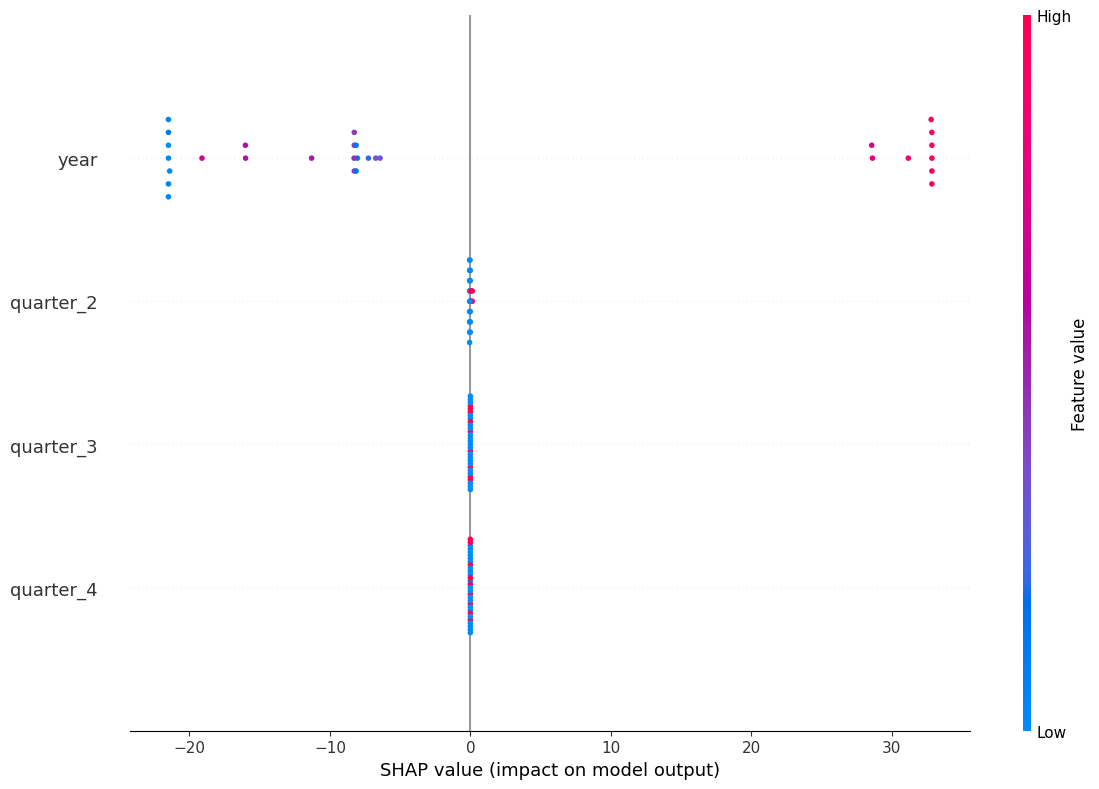

SHAP Values for Target c2_dist:


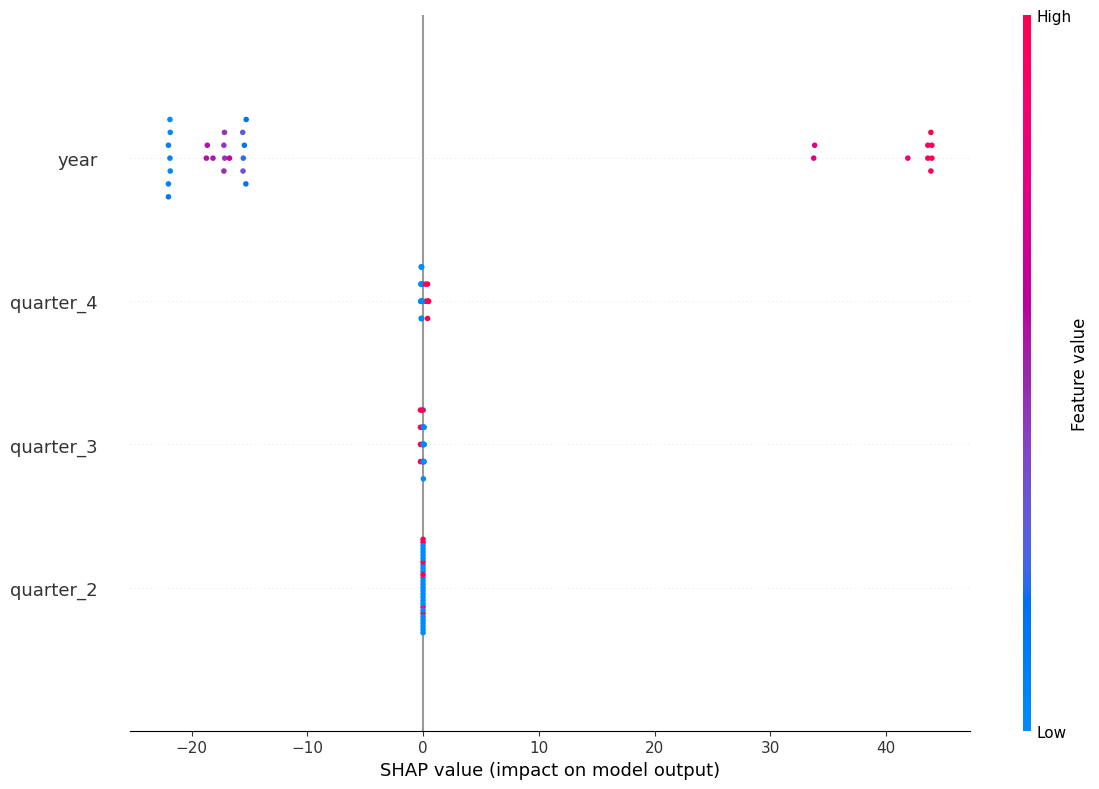

SHAP Values for Target c3_dist:


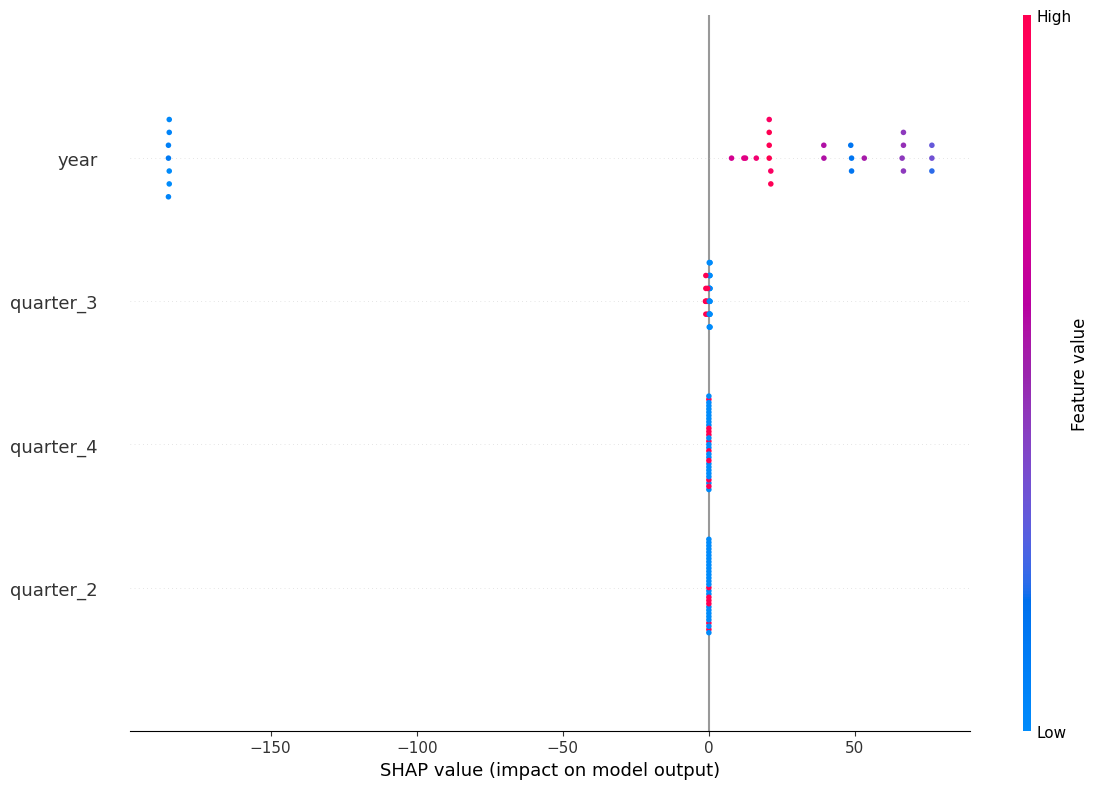

SHAP Values for Target c4_dist:


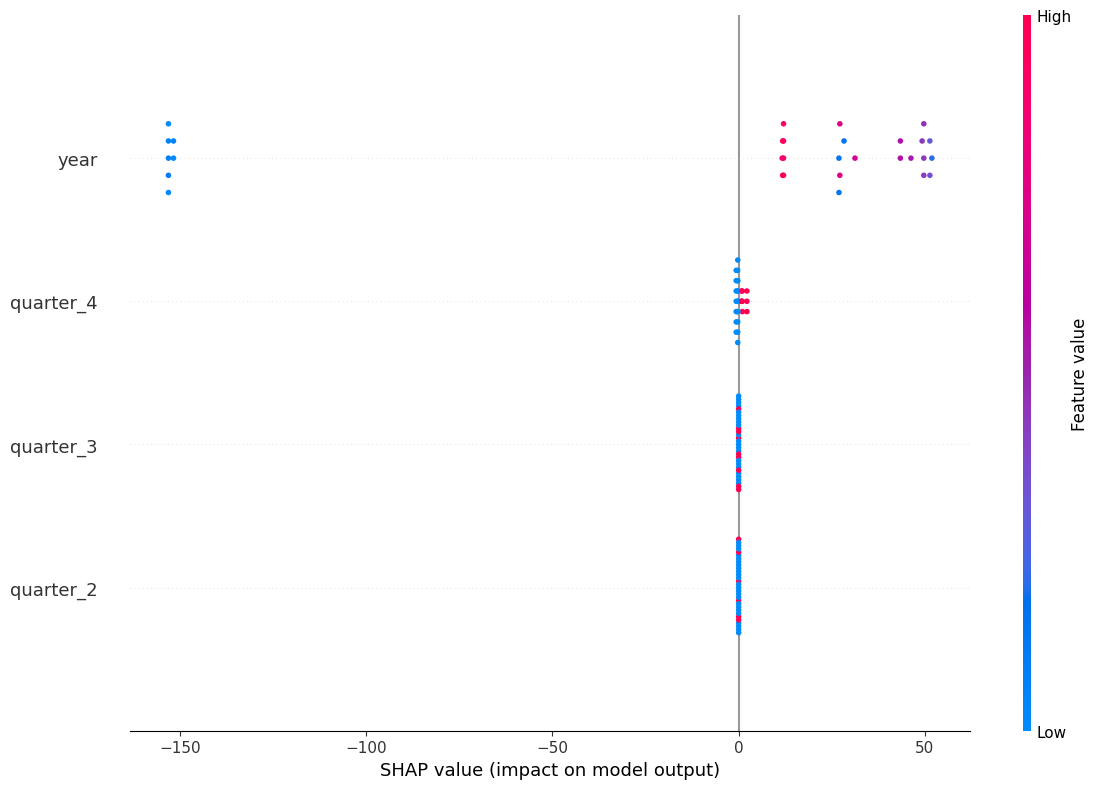

SHAP Values for Target c5_dist:


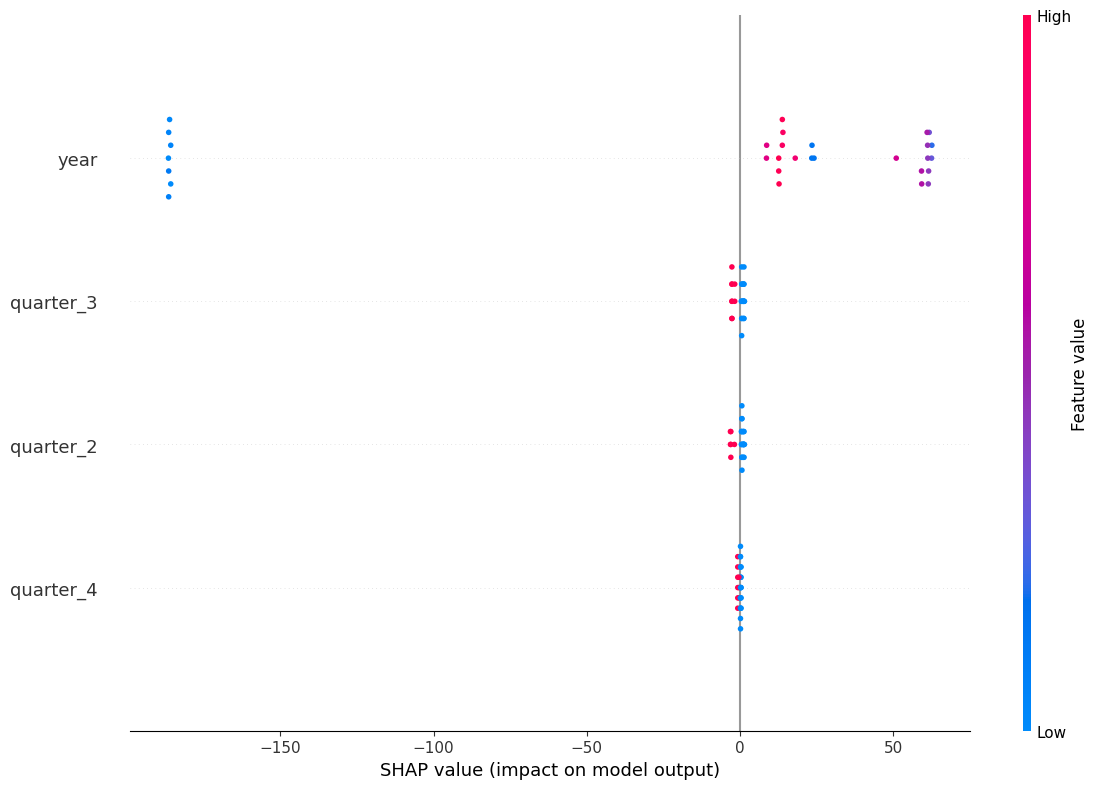

SHAP Values for Target c6_dist:


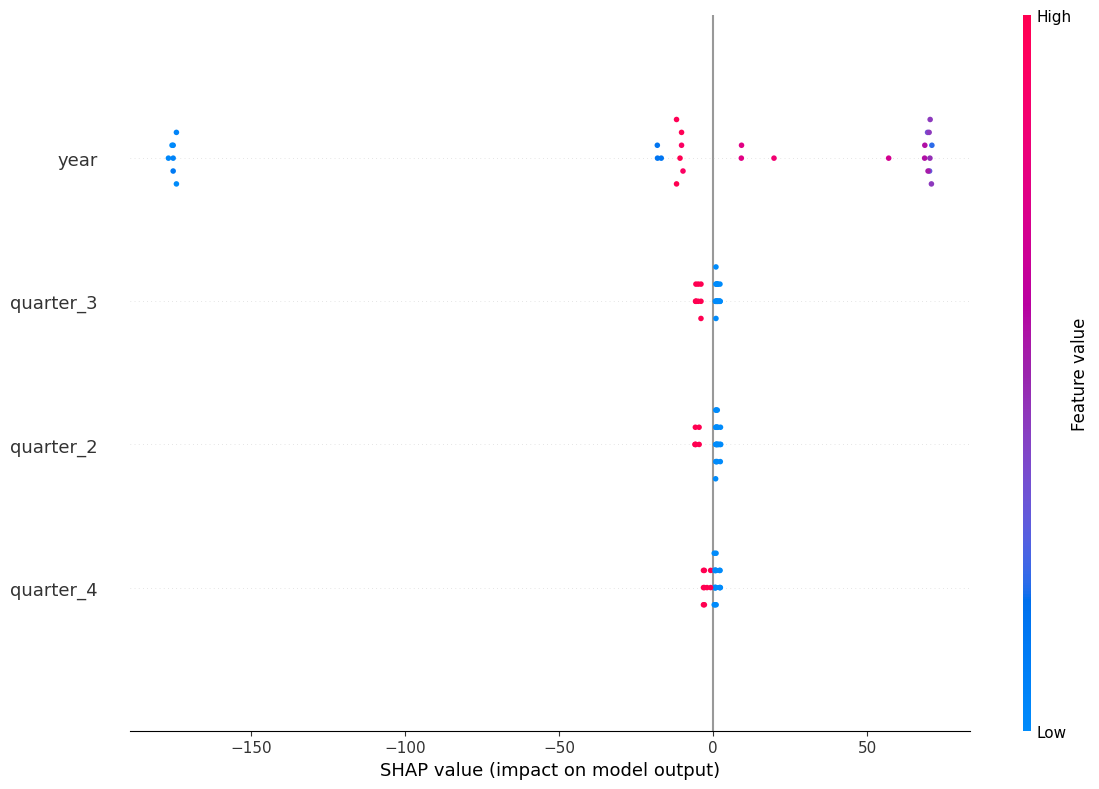

SHAP Values for Target c7_dist:


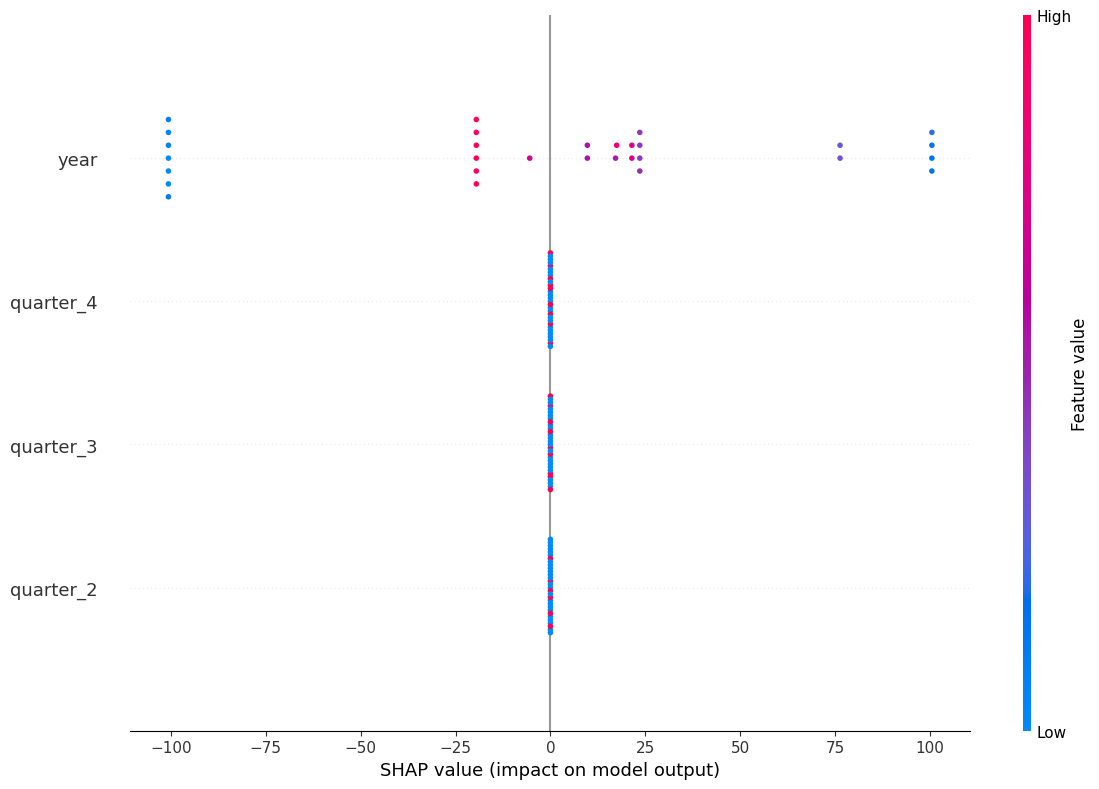

SHAP Values for Target c8_dist:


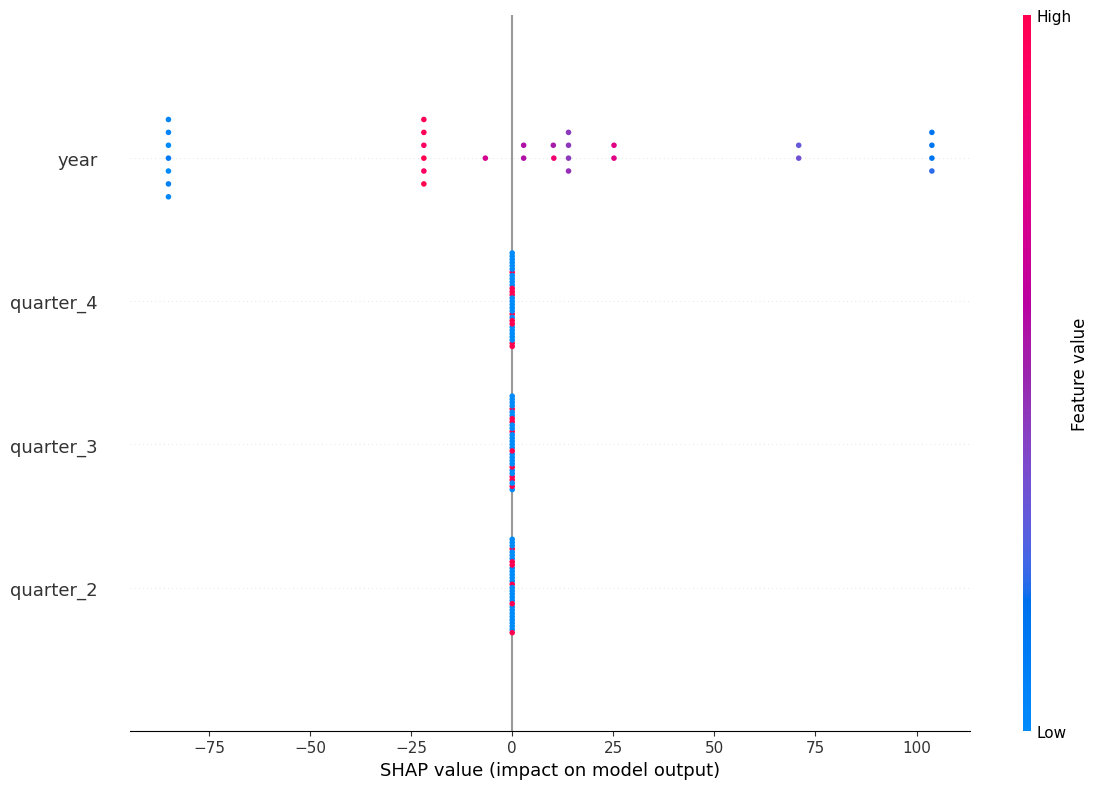

In [ ]:
import shap

for idx, regressor in enumerate(grid_search.best_estimator_.estimators_):
    print(f"SHAP Values for Target {y.columns[idx]}:")

    explainer = shap.TreeExplainer(regressor)
    shap_values = explainer.shap_values(X_test)  # SHAP values for the test set

    # Visualize overall feature importance
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_size=(12, 8))

    # Visualize explanation for a single prediction
    shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], feature_names=X_test.columns)


# Train multi-output regressor

In [ ]:

for i in y.columns:
  y[i]=medfilt(y[i], kernel_size=5)

y.tail()

<ipython-input-6-055d12c7894f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[i]=medfilt(y[i], kernel_size=5)


,c1_dist,c2_dist,c3_dist,c4_dist,c5_dist,c6_dist,c7_dist,c8_dist
142,145.401573,81.494220,1035.811759,1027.231301,2286.479200,2446.127365,1946.979455,2125.705765
143,145.401573,81.494220,1035.811759,1028.048637,2537.558669,2720.020037,1942.374063,2121.280981
144,151.716841,88.141931,1035.811759,1027.231301,2464.208798,2528.677520,1942.374063,2121.280981
145,151.716841,88.141931,1035.811759,1023.249725,2464.208798,2528.677520,1930.565979,2110.030568
146,142.021125,75.584390,1031.004365,1023.000000,2464.208798,2528.677520,1924.370546,2104.219095


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.05, n_estimators=50)

multi_output_model = MultiOutputRegressor(lgb_model)



# Train the model
multi_output_model.fit(X_train, y_train)

In [ ]:
# Predict on the test set
y_pred = multi_output_model.predict(X_test)

In [ ]:
# Evaluate performance
range=[]
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))  # RMSE for each target
print("Testing RMSE for each control point:", rmse)


for i in df.columns[1:-2]:
    col_min = min(df[i])
    col_max = max(df[i])
    range.append([col_min, col_max])


Testing RMSE for each control point: [ 9.15647158  7.27043298 65.11307386 58.16222227 80.39565658 86.76700978
 74.45445695 80.25107639]


In [ ]:
for i in rmse:
  index_r=int(np.where(rmse==i)[0])
  err_percentage=i/(range[index_r][1]-range[index_r][0])*100
  print(index_r, '->', err_percentage)

0 -> 5.3244700119655795
1 -> 4.344633898076348
2 -> 12.861918873445463
3 -> 11.844134077889366
4 -> 14.833297630254425
5 -> 15.03289997404947
6 -> 14.539089876511799
7 -> 15.690699703761506


<ipython-input-11-d2d1e570ef13>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index_r=int(np.where(rmse==i)[0])


In [ ]:
r2_test = r2_score(y_test, y_pred)
print(f'r squared score: {r2_test}')

r squared score: 0.7326793994096793


In [ ]:
# Calculate baseline predictions (mean of each target column in training data)
baseline_predictions = np.tile(y_train.mean(axis=0), (len(y_test), 1))

# Compute RMSE for each target column
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions, multioutput='raw_values'))

baseline_r2=r2_score(y_test, baseline_predictions)

print(f'baseline r2 score : {baseline_r2}')

baseline r2 score : -0.031226485424566325


In [ ]:
for i in baseline_rmse:
  index_r=int(np.where(baseline_rmse==i)[0])
  err_percentage=i/(range[index_r][1]-range[index_r][0])*100
  print(index_r, '->', err_percentage)

0 -> 13.326835896718139
1 -> 16.58176628310822
2 -> 27.965021873967384
3 -> 24.722561720716975
4 -> 28.624080141298357
5 -> 27.079674354217875
6 -> 23.533538621956804
7 -> 23.592090536151993


<ipython-input-13-3a774f9c6244>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index_r=int(np.where(baseline_rmse==i)[0])


In [ ]:
y_train_pred = multi_output_model.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred, multioutput='raw_values'))

print("Training RMSE for each control point:", rmse_train)

Training RMSE for each control point: [ 9.4227784   8.36916445 61.73057092 54.37447178 76.9009425  84.79284808
 73.06680758 76.02301911]


In [ ]:
for i in rmse_train:
  index_r=int(np.where(rmse_train==i)[0])
  err_percentage=i/(range[index_r][1]-range[index_r][0])*100
  print(index_r, '->', err_percentage)

0 -> 5.479326896800499
1 -> 5.001209095879468
2 -> 12.19376613902132
3 -> 11.072797927251294
4 -> 14.188509884656822
5 -> 14.690864730041172
6 -> 14.268116724174892
7 -> 14.864029457344207


<ipython-input-15-17dd42db85c4>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index_r=int(np.where(rmse_train==i)[0])
